In [1]:
from common.constant import Constants
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import torch
import torch.nn as nn
import torch.optim as optim
from scipy.stats import pearsonr
import warnings
%matplotlib inline
warnings.filterwarnings("ignore")

In [2]:
# read in data
data = pd.read_excel(Constants.DATA_PATH, sheet_name=0)
data.dropna(subset=["检测孕周", "GC含量", "孕妇BMI", "Y染色体浓度"], inplace=True)
data

,序号,孕妇代码,年龄,身高,体重,末次月经,IVF妊娠,检测日期,检测抽血次数,检测孕周,...,Y染色体浓度,X染色体浓度,13号染色体的GC含量,18号染色体的GC含量,21号染色体的GC含量,被过滤掉读段数的比例,染色体的非整倍体,怀孕次数,生产次数,胎儿是否健康
0,1,A001,31,160.0,72.00,2023-02-01 00:00:00,自然受孕,20230429,1,11w+6,...,0.025936,0.038061,0.377069,0.389803,0.399399,0.027484,NaN,1,0,是
1,2,A001,31,160.0,73.00,2023-02-01 00:00:00,自然受孕,20230531,2,15w+6,...,0.034887,0.059572,0.371542,0.384771,0.391706,0.019617,NaN,1,0,是
2,3,A001,31,160.0,73.00,2023-02-01 00:00:00,自然受孕,20230625,3,20w+1,...,0.066171,0.075995,0.377449,0.390582,0.399480,0.022312,NaN,1,0,是
3,4,A001,31,160.0,74.00,2023-02-01 00:00:00,自然受孕,20230716,4,22w+6,...,0.061192,0.052305,0.375613,0.389251,0.397212,0.023280,NaN,1,0,是
4,5,A002,32,149.0,74.00,2023-11-09 00:00:00,自然受孕,20240219,1,13w+6,...,0.059230,0.059708,0.380260,0.393618,0.404868,0.024212,NaN,2,1,否
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1077,1078,A266,30,159.0,83.35,2022-12-29,自然受孕,2023-05-02 00:00:00,4,17w+5,...,0.099052,0.056686,0.376861,0.389914,0.397090,0.017951,T18,1,0,是
1078,1079,A267,28,155.0,73.76,2023-02-25,自然受孕,2023-05-17 00:00:00,1,11w+4,...,0.098706,0.023663,0.377597,0.387901,0.404293,0.022549,T21,1,0,是
1079,1080,A267,28,155.0,74.06,2023-02-25,自然受孕,2023-05-24 00:00:00,2,12w+4,...,0.102088,0.080264,0.379041,0.391748,0.400433,0.021330,NaN,1,0,是
1080,1081,A267,28,155.0,74.74,2023-02-25,自然受孕,2023-05-31 00:00:00,3,13w+4,...,0.109855,0.074050,0.379107,0.388544,0.401030,0.022013,NaN,1,0,是


In [3]:
weeks_days = data["检测孕周"].str.split(r"[wW]", expand=True)
data["孕天"] = weeks_days[0].astype(int) * 7 + weeks_days[1].fillna("0").replace("", "0").astype(int)

# data = data[(0.4 <= data["GC含量"]) & (data["GC含量"] <= 0.6)]

data["检测日期"] = pd.to_datetime(data["检测日期"], format="%Y%m%d")
data["末次月经"] = pd.to_datetime(data["末次月经"], format="%Y-%m-%d")
data["delta_days"] = (data["检测日期"] - data["末次月经"]).dt.days - data["孕天"]
# data = data[(data["delta_days"] >= -7) & (data["delta_days"] <= 7)]
# data = data[abs(data["delta_days"]) <= 3]
data = data[data["delta_days"] == 0]

data

,序号,孕妇代码,年龄,身高,体重,末次月经,IVF妊娠,检测日期,检测抽血次数,检测孕周,...,13号染色体的GC含量,18号染色体的GC含量,21号染色体的GC含量,被过滤掉读段数的比例,染色体的非整倍体,怀孕次数,生产次数,胎儿是否健康,孕天,delta_days
9,10,A003,35,160.0,78.70,2023-02-20,自然受孕,2023-05-22,1,13w,...,0.381178,0.394178,0.403653,0.021138,T21,≥3,1,是,91,0.0
12,13,A003,35,160.0,79.72,2023-02-20,自然受孕,2023-06-17,2,16w+5,...,0.377922,0.391794,0.401705,0.022111,T21,≥3,1,是,117,0.0
237,238,A055,25,163.0,93.00,2023-02-23,自然受孕,2023-05-20,1,12w+2,...,0.374986,0.387093,0.395632,0.021033,T21,2,1,是,86,0.0
241,242,A055,23,163.0,98.00,2023-02-23,自然受孕,2023-08-06,4,23w+3,...,0.374899,0.387981,0.396296,0.019835,T21,2,1,是,164,0.0
682,683,A168,26,157.0,74.87,2023-01-20,自然受孕,2023-04-10,1,11w+3,...,0.375233,0.390173,0.403319,0.019448,NaN,1,0,是,80,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1077,1078,A266,30,159.0,83.35,2022-12-29,自然受孕,2023-05-02,4,17w+5,...,0.376861,0.389914,0.397090,0.017951,T18,1,0,是,124,0.0
1078,1079,A267,28,155.0,73.76,2023-02-25,自然受孕,2023-05-17,1,11w+4,...,0.377597,0.387901,0.404293,0.022549,T21,1,0,是,81,0.0
1079,1080,A267,28,155.0,74.06,2023-02-25,自然受孕,2023-05-24,2,12w+4,...,0.379041,0.391748,0.400433,0.021330,NaN,1,0,是,88,0.0
1080,1081,A267,28,155.0,74.74,2023-02-25,自然受孕,2023-05-31,3,13w+4,...,0.379107,0.388544,0.401030,0.022013,NaN,1,0,是,95,0.0


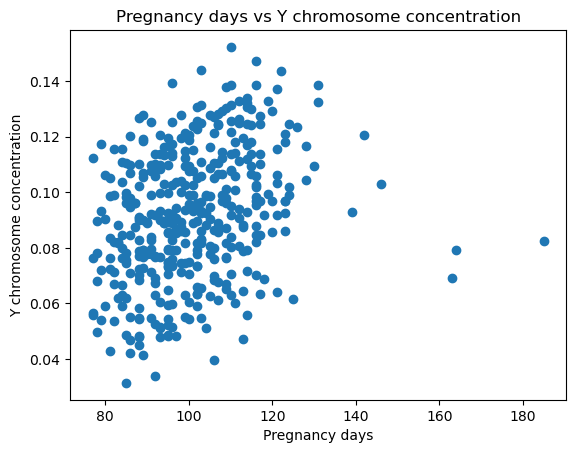

In [4]:
plt.scatter(data["孕天"], data["Y染色体浓度"])
plt.xlabel("Pregnancy days")
plt.ylabel("Y chromosome concentration")
plt.title("Pregnancy days vs Y chromosome concentration")
plt.show()

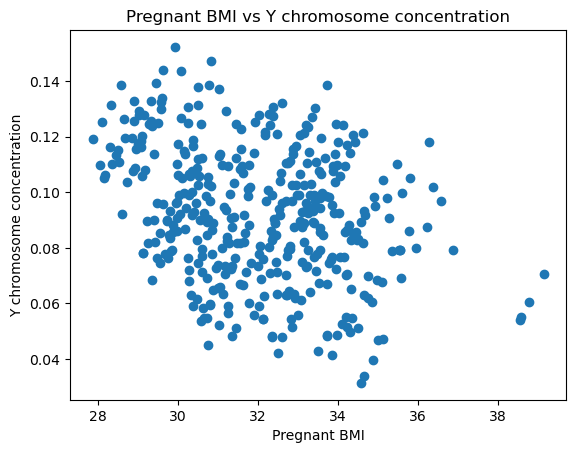

In [5]:
plt.scatter(data["孕妇BMI"], data["Y染色体浓度"])
plt.xlabel("Pregnant BMI")
plt.ylabel("Y chromosome concentration")
plt.title("Pregnant BMI vs Y chromosome concentration")
plt.show()

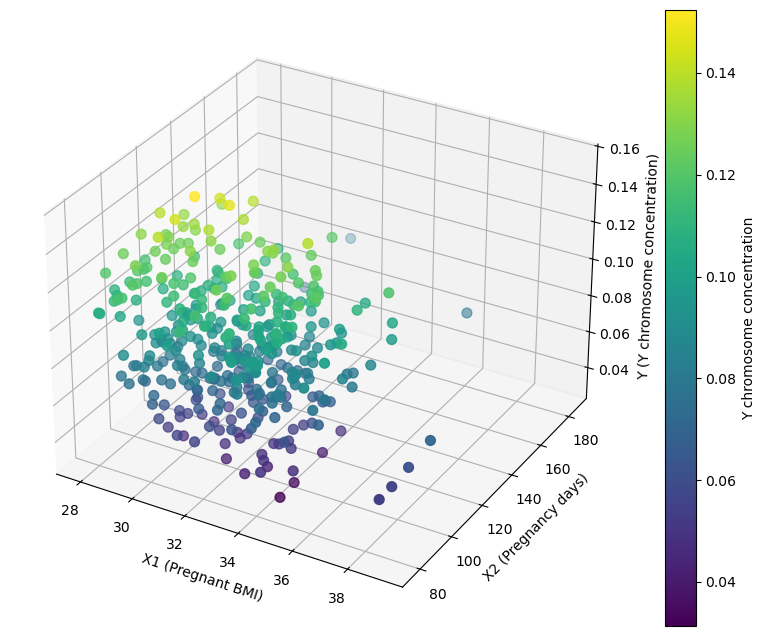

In [6]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection="3d")

# 用颜色表现 Y 的大小
sc = ax.scatter(data["孕妇BMI"], data["孕天"], data["Y染色体浓度"], c=data["Y染色体浓度"], cmap="viridis", s=50)

ax.set_xlabel("X1 (Pregnant BMI)")
ax.set_ylabel("X2 (Pregnancy days)")
ax.set_zlabel("Y (Y chromosome concentration)")
plt.colorbar(sc, label="Y chromosome concentration")
plt.show()

In [7]:
Y1 = data["Y染色体浓度"]
X1 = data["孕妇BMI"]
X2 = data["孕天"]
print("X1: BMI, X2: 孕周， Y: Y染色体浓度")

corr, p_value = pearsonr(X1, X2)
print("X1, X2 r=" , corr , " p=", p_value)
corr, p_value = pearsonr(X1, Y1)
print("X1, Y r=" , corr , " p=", p_value)
corr, p_value = pearsonr(X2, Y1)
print("X2, Y r=" , corr , " p=", p_value)

X1: BMI, X2: 孕周， Y: Y染色体浓度
X1, X2 r= 0.11360784429018868  p= 0.0223825415413845
X1, Y r= -0.31542501242465604  p= 8.776738357669694e-11
X2, Y r= 0.29639732580960465  p= 1.2312468512803206e-09


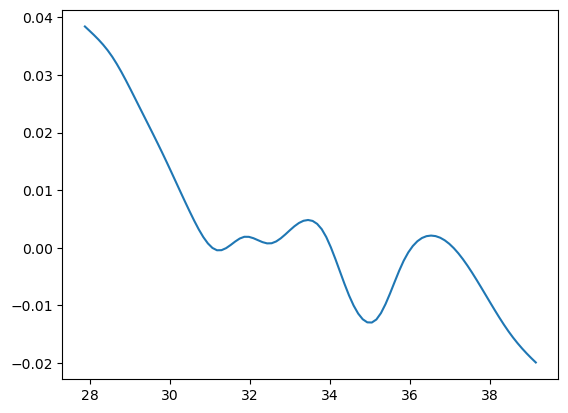

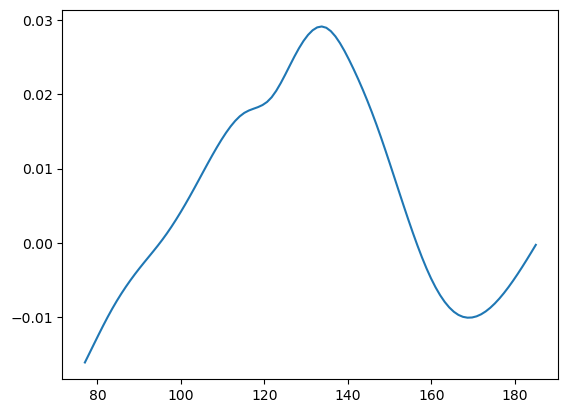

In [8]:
from pygam import LinearGAM, s

# 假设 X 是二维数组，y 是响应变量
X = data[["孕妇BMI", "孕天"]].values
y = data["Y染色体浓度"].values
gam = LinearGAM(s(0) + s(1)).fit(X, y)

# 查看每个变量的非线性效果
import matplotlib.pyplot as plt
for i, term in enumerate(gam.terms):
    if term.isintercept:
        continue
    XX = gam.generate_X_grid(term=i)
    plt.plot(XX[:, i], gam.partial_dependence(term=i, X=XX))
    plt.show()